In [201]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
########## Block 1 ############## <-- Please refer this block number when you ask questions
import numpy as np
# package for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

from pyDOE import lhs
import emcee

import time, os, pickle
# scikit-learn: machine learning in Python
# https://scikit-learn.org/stable/tutorial/basic/tutorial.html
# In this example, we are using the principal component analysis 
# and the Gaussian process regression as implemented in sklearn.
# Detailed documentation of these modules:
# Principal component analysis (PCA): 
# https://scikit-learn.org/stable/modules/decomposition.html
# Gaussian process gressor (GPR)):
# https://scikit-learn.org/stable/modules/gaussian_process.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from scipy.interpolate import interp1d
from scipy.integrate import quad
# suppression warning messages
import warnings
warnings.filterwarnings('ignore')
from glob import glob

# some plot settings, not important
fontsize  = 12
plt.rcdefaults()
plt.rcParams.update({
    'font.size': fontsize,
    'legend.fontsize': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': True,
    'axes.spines.right': True,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
})

cr, cg, cb = plt.cm.Reds(.6), plt.cm.Greens(.6), plt.cm.Blues(.6)

In [202]:
# Genearte correlated random function as samples of (qhat/T^3)/mean
def Mean_f(x, mean):
    return mean*np.ones_like(x)
def Var_f(x, sigma, L, N, random_state):
    kernel = sigma**2 * kernels.RBF(length_scale=L)  
    GP = GPR(kernel=kernel)
    y = GP.sample_y(np.atleast_2d(x).T, n_samples=N, random_state=random_state)
    return y
def Get_f(x, mean, sigma, L, N, random_state=31415):
    # sigma_gaussian
    sigma_gaussian = np.sqrt(np.log(sigma**2+1))
    # get mean
    meanf = Mean_f(x, mean)
    # get Gaussian Varaiton
    varf = Var_f(x, sigma_gaussian, L, N, random_state=random_state)
    # convert Gaussian varation to positive definite log-normal fluctuation
    Pvarf = np.exp(
        varf-sigma_gaussian**2/2.)
    print(Pvarf[0].mean(), Pvarf[0].std())
    f = Pvarf.T*meanf
    return f, meanf, varf

0.9133115814319654 0.6748992986301335
1.0047880358715626 0.8384847723791581


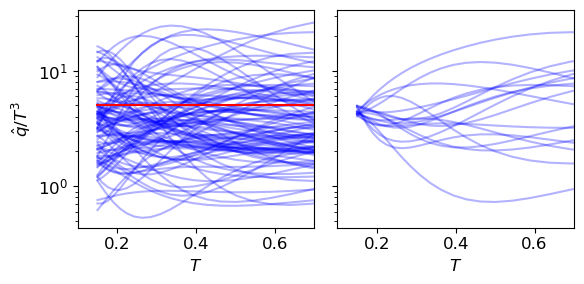

In [203]:
fig, (ax, ax1) = plt.subplots(ncols=2,nrows=1,figsize=(6,3), sharex=True, sharey=True)
Tc = 0.15
lnT = np.linspace(np.log(Tc), np.log(5*Tc), 21)
T = np.exp(lnT)

#"""
qhats, mean_qhats, var_qhats = Get_f(lnT, 5, .8, np.log(2/1), 100)
qhats_prior, _, _ = Get_f(lnT, 5, .8, np.log(2/1), 10000)
with open("Parameters/qhat_design_tables.dat", 'w') as f:
    f.write( ("#"+"{:1.5e}\t"*len(T)+"\n").format(*T) )
    for it in qhats:
        f.write( ("{:1.5e}\t"*len(T)+"\n").format(*it) )
#"""
#qhats = np.loadtxt("Parameters/qhat_design_tables.dat")

_ = ax.plot(T, qhats.T, color='b', alpha=0.3)
_ = ax.plot(T, mean_qhats, 'r-')
q0 = qhats[:, 0]
q3 = qhats[:, 0]
cut = (q3<5) & (q3>4)
_ = ax1.plot(T, qhats[cut,:].T, color='b', alpha=0.3)
ax.set_xlim(0.1,.7)
#ax.set_ylim(0,20)
ax.set_xlabel(r"$T$")
ax1.set_xlabel(r"$T$")
ax.set_ylabel(r"$\hat{q}/T^3$")
ax.semilogy()
plt.tight_layout()
plt.savefig("qhat_sample.png")

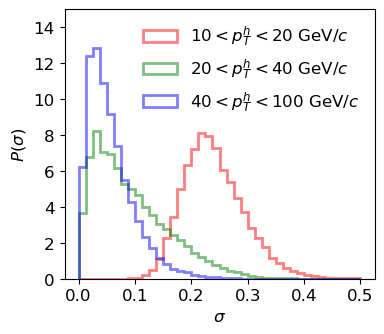

In [211]:
#### Block 23 #### Please refer to this number in your questions
fig, ax = plt.subplots(1,1,figsize=(4,3.5))
name = "Results/AuAu200-PbPb2760-PbPb5020/pT-{}-{}"
colors = 'rgb'
for i, (pTl, pTh) in enumerate([[10,20],[20,40],[40,100]]): 
    samples_df=pd.read_csv(name.format(pTl, pTh)+"/chain.dat")
    samples = samples_df.values
    sigma = samples[:,-1]
    ax.hist(sigma, bins=np.linspace(0,.5,41),
            histtype='step', color=colors[i], 
            density=True, alpha=.5,lw=2, 
            label=r'${}<p_T^h<{}$ GeV/$c$'.format(pTl, pTh))
ax.legend()
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$P(\sigma)$")
ax.set_ylim(0,15)
plt.savefig("Theory_uncertainty_esitmation.png", dpi=300)

In [30]:
Npc=5
# Transform the design into the original space
SS  =  StandardScaler(copy=True)
pca = PCA(copy=True, whiten=True, svd_solver='full')
# Keep only the first `npc` principal components
pc_param_data = pca.fit_transform(SS.fit_transform(np.log(qhats))) [:,:Npc]

# The transformation matrix from PC to Physical space
inverse_param_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) * SS.scale_ 
inverse_param_matrix = inverse_param_matrix[:Npc,:] # Z --> [Nch, v2]

In [31]:
def PC2qhat(p):
    res = p @ inverse_param_matrix + SS.mean_
    return np.exp(res)

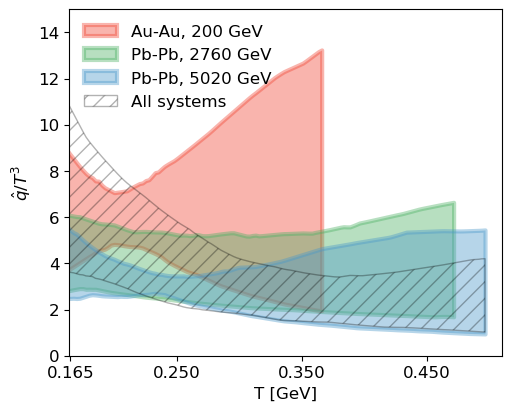

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharex=False, sharey=False, constrained_layout=True)
T3, T2, T1 = 0.3681, 0.4723, 0.4978
colors = cr, cg, cb , 'k'
newT = np.linspace(.16,.66,200)
for i, sys in enumerate(['AuAu200', 'PbPb2760', 'PbPb5020', 'AuAu200-PbPb2760-PbPb5020']):

    label =[ "Au-Au, 200 GeV", "Pb-Pb, 2760 GeV", "Pb-Pb, 5020 GeV", 'All systems'][i]
    name = "Results/{}/pT-10-100".format(sys)
    samples_df=pd.read_csv(name+"/chain.dat")
    samples = samples_df.values
    
    
    #### Block 26 #### Please refer to this number in your questions
    Nsamples = 1000
    Nthin = samples_df.size//Nsamples

    posterior_qhat = np.array([
        interp1d(T,PC2qhat(it[:-1]))(newT) for it in samples_df.iloc[::Nthin,:].values
    ])

    # plot posterior, display 30%, 60%, and 90% credible limits
    CLbins = [95]
    for CL, opacity in zip(CLbins, [.3]):
        lower, upper = np.percentile(posterior_qhat, [50-CL/2., 50+CL/2.], axis=0)
        if sys=='AuAu200':
            ax.fill_between(newT[newT<T3],lower[newT<T3], upper[newT<T3], color=colors[i], alpha=.4, label=label,lw=3)
        if sys=='PbPb2760':
            ax.fill_between(newT[newT<T2],lower[newT<T2], upper[newT<T2], color=colors[i], alpha=.4, label=label,lw=3)
        if sys=='PbPb5020':
            ax.fill_between(newT[newT<T1],lower[newT<T1], upper[newT<T1], color=colors[i], alpha=.4, label=label,lw=3)
        if sys=='AuAu200-PbPb2760-PbPb5020':
            ax.fill_between(newT[newT<T1],lower[newT<T1], upper[newT<T1], edgecolor=colors[i], facecolor='none', hatch='//', alpha=.3, label=label,lw=1)
        
ax.set_ylim(0,15)
ax.set_xlim(.164,.51)
ax.legend(loc='upper left')
ax.set_xlabel('T [GeV]')
ax.set_ylabel('$\hat{q}/T^3$')


ax.set_xticks([0.165, 0.25, 0.35, 0.45])
#save_fig("qhat")      
plt.savefig("qhat_different_systems.png", dpi=300)

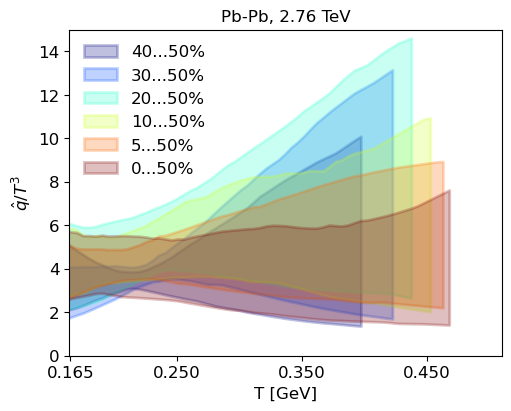

In [158]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharex=False, sharey=False, constrained_layout=True)
T3, T2, T1 = 0.3681, 0.4723, 0.4978
colors = cr, cg, cb , 'k'
Tmaxes = [0.401,0.4238,0.441,0.4552,0.4648, 0.4723]
newT = np.linspace(.16,.66,100)
for i, sys in enumerate(['40-50','30-40+40-50',
                         '20-30+30-40+40-50',
                         '10-20+20-30+30-40+40-50',
                         '5-10+10-20+20-30+30-40+40-50',
                         '0-5+5-10+10-20+20-30+30-40+40-50'
                        ]):
    cc = plt.cm.jet(i/5)
    name = "Results/PbPb2760/{}/".format(sys)
    samples_df=pd.read_csv(name+"/chain.dat")
    samples = samples_df.values
    Tmax = Tmaxes[i]
    
    
    #### Block 26 #### Please refer to this number in your questions
    Nsamples = 1000
    Nthin = samples_df.size//Nsamples

    posterior_qhat = np.array([
        interp1d(T,PC2qhat(it[:-1]))(newT) for it in samples_df.iloc[::Nthin,:].values
    ])

    # plot posterior, display 30%, 60%, and 90% credible limits
    CLbins = [95]
    cut = newT<Tmax
    for CL, opacity in zip(CLbins, [.3]):
        lower, upper = np.percentile(posterior_qhat, [50-CL/2., 50+CL/2.], axis=0)
        ax.fill_between(newT[cut],lower[cut], upper[cut], color=cc, alpha=.25, label=sys.split('-')[0]+'...50%',lw=2)

ax.set_ylim(0,15)
ax.set_xlim(.164,.51)
ax.legend(loc='upper left')
ax.set_xlabel('T [GeV]')
ax.set_ylabel('$\hat{q}/T^3$')
ax.set_xticks([0.165, 0.25, 0.35, 0.45])
#save_fig("qhat")      
ax.set_title("Pb-Pb, 2.76 TeV")
plt.savefig("qhat_different_centrality_PbPb2760.png", dpi=300)

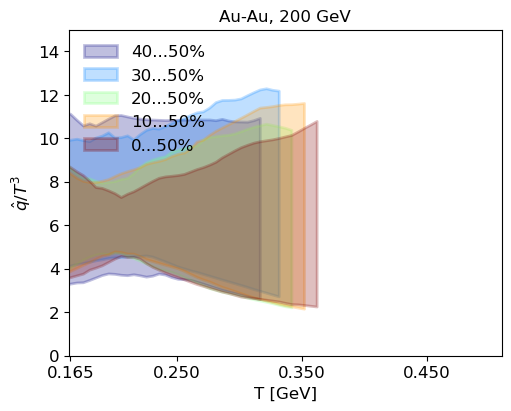

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharex=False, sharey=False, constrained_layout=True)
T3, T2, T1 = 0.3681, 0.4723, 0.4978
colors = cr, cg, cb , 'k'
Tmaxes = [.3652,.3557,.3459,.3331,.3173][::-1]
newT = np.linspace(.16,.66,100)
for i, sys in enumerate(['40-50',
                         '30-40+40-50',
                         '20-30+30-40+40-50',
                         '10-20+20-30+30-40+40-50',
                         '0-10+10-20+20-30+30-40+40-50'
                        ]):
    cc = plt.cm.jet(i/4)
    name = "Results/AuAu200/{}/".format(sys)
    samples_df=pd.read_csv(name+"/chain.dat")
    samples = samples_df.values
    Tmax = Tmaxes[i]
    
    
    #### Block 26 #### Please refer to this number in your questions
    Nsamples = 1000
    Nthin = samples_df.size//Nsamples

    posterior_qhat = np.array([
        interp1d(T,PC2qhat(it[:-1]))(newT) for it in samples_df.iloc[::Nthin,:].values
    ])

    # plot posterior, display 30%, 60%, and 90% credible limits
    CLbins = [95]
    cut = newT<Tmax
    for CL, opacity in zip(CLbins, [.3]):
        lower, upper = np.percentile(posterior_qhat, [50-CL/2., 50+CL/2.], axis=0)
        ax.fill_between(newT[cut],lower[cut], upper[cut], color=cc, alpha=.25, label=sys.split('-')[0]+'...50%',lw=2)

ax.set_ylim(0,15)
ax.set_xlim(.164,.51)
ax.legend(loc='upper left')
ax.set_xlabel('T [GeV]')
ax.set_ylabel('$\hat{q}/T^3$')
ax.set_xticks([0.165, 0.25, 0.35, 0.45])
#save_fig("qhat")      
ax.set_title("Au-Au, 200 GeV")
plt.savefig("qhat_different_centrality_AuAu200", dpi=300)

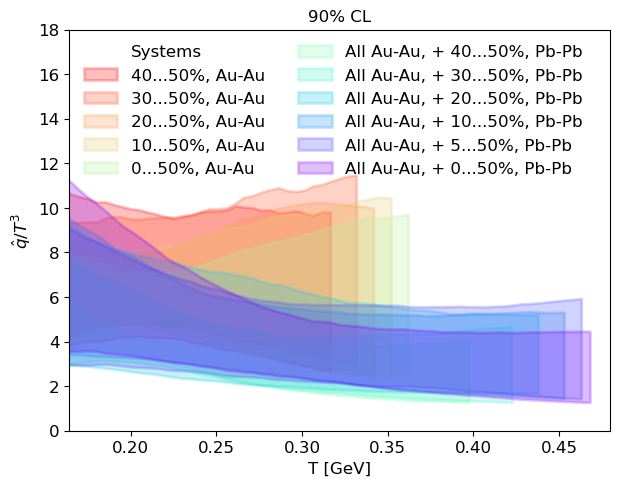

In [200]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5,5), sharex=False, sharey=False, constrained_layout=True)
T3, T2, T1 = 0.3681, 0.4723, 0.4978
colors = cr, cg, cb , 'k'
Tmaxes = [.3652,.3557,.3459,.3331,.3173][::-1]
newT = np.linspace(.16,.66,100)
ax.plot([],[], alpha=0, label='Systems')
CM = plt.cm.rainbow
for i, sys in enumerate(['40-50',
                         '30-40+40-50',
                         '20-30+30-40+40-50',
                         '10-20+20-30+30-40+40-50',
                         '0-10+10-20+20-30+30-40+40-50'
                        ]):
    cc =CM(1-i/10)
    name = "Results/AuAu200/{}/".format(sys)
    samples_df=pd.read_csv(name+"/chain.dat")
    samples = samples_df.values
    Tmax = Tmaxes[i]
    
    
    #### Block 26 #### Please refer to this number in your questions
    Nsamples = 4000
    Nthin = samples_df.size//Nsamples

    posterior_qhat = np.array([
        interp1d(T,PC2qhat(it[:-1]))(newT) for it in samples_df.iloc[::Nthin,:].values
    ])

    # plot posterior, display 30%, 60%, and 90% credible limits
    CLbins = [90]
    cut = newT<Tmax
    for CL, opacity in zip(CLbins, [.2]*2):
        lower, upper = np.percentile(posterior_qhat, [50-CL/2., 50+CL/2.], axis=0)
        ax.fill_between(newT[cut],lower[cut], upper[cut], color=cc, alpha=.25, label=sys.split('-')[0]+'...50%, Au-Au',lw=2)

Tmaxes = [0.401,0.4238,0.441,0.4552,0.4648, 0.4723]
for i, sys in enumerate(['40-50',
                         '30-40+40-50',
                         '20-30+30-40+40-50',
                         '10-20+20-30+30-40+40-50',
                         '5-10+10-20+20-30+30-40+40-50',
                         '0-5+5-10+10-20+20-30+30-40+40-50',
                        ]):
    cc = CM(1-(i+5)/10)
    name = "Results/AuAu200-PbPb2760/{}/".format(sys)
    samples_df=pd.read_csv(name+"/chain.dat")
    samples = samples_df.values
    Tmax = Tmaxes[i]
    
    
    #### Block 26 #### Please refer to this number in your questions
    Nsamples = 4000
    Nthin = samples_df.size//Nsamples

    posterior_qhat = np.array([
        interp1d(T,PC2qhat(it[:-1]))(newT) for it in samples_df.iloc[::Nthin,:].values
    ])

    # plot posterior, display 30%, 60%, and 90% credible limits
    CLbins = [90]
    cut = newT<Tmax
    for CL, opacity in zip(CLbins, [.2]*2):
        lower, upper = np.percentile(posterior_qhat, [50-CL/2., 50+CL/2.], axis=0)
        ax.fill_between(newT[cut],lower[cut], upper[cut], color=cc, alpha=.25, label='All Au-Au, + '+sys.split('-')[0]+'...50%, Pb-Pb',lw=2)

        
ax.set_ylim(0,18)
ax.set_xlim(.164,.48)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('T [GeV]')
ax.set_ylabel('$\hat{q}/T^3$')
ax.set_title("90% CL")
plt.tight_layout(True)  
plt.savefig("qhat_different_centrality_AuAu200_PbPb2760_CL90", dpi=300)

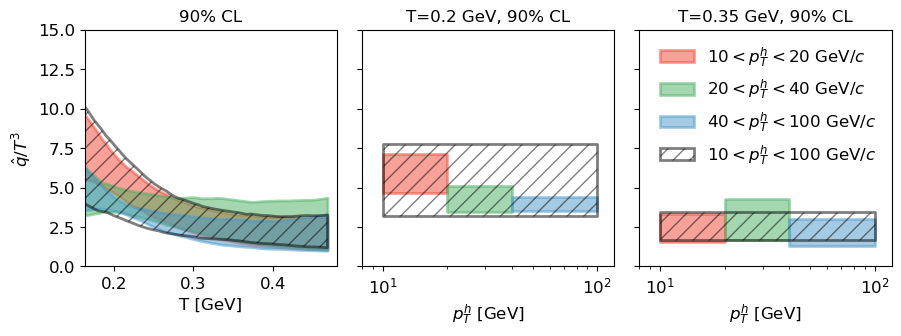

In [237]:
#### Block 23 #### Please refer to this number in your questions
fig, axes = plt.subplots(1,3,figsize=(9,3.5),sharey=True)
name = "Results/AuAu200-PbPb2760-PbPb5020/pT-{}-{}"
colors = cr, cg, cb , 'k'
Tmax = 0.47
for i, (pTl, pTh) in enumerate([[10,20],[20,40],[40,100], [10,100]]): 
    samples_df=pd.read_csv(name.format(pTl, pTh)+"/chain.dat")
    samples = samples_df.values
    cc = colors[i]
    #### Block 26 #### Please refer to this number in your questions
    Nsamples = 4000
    Nthin = samples_df.size//Nsamples

    posterior_qhat = np.array([
        interp1d(T,PC2qhat(it[:-1]))(newT) for it in samples_df.iloc[::Nthin,:].values
    ])

    # plot posterior, display 30%, 60%, and 90% credible limits
    CLbins = [90]
    cut = newT<Tmax
    ax = axes[0]
    for CL, opacity in zip(CLbins, [.2]*2):
        lower, upper = np.percentile(posterior_qhat, [50-CL/2., 50+CL/2.], axis=0)
        if cc=='k':
            ax.fill_between(newT[cut],lower[cut], upper[cut], edgecolor=cc,
                       facecolor='none', hatch='//', alpha=.5,
                       label=r'${}<p_T^h<{}$ GeV/$c$'.format(pTl, pTh),
                       lw=2)
        else:
            ax.fill_between(newT[cut],lower[cut], upper[cut], color=cc, alpha=.5,
                       label=r'${}<p_T^h<{}$ GeV/$c$'.format(pTl, pTh),
                       lw=2)
    posterior_qhat_fixT = np.array([
        interp1d(T,PC2qhat(it[:-1]))(0.2) for it in samples_df.iloc[::Nthin,:].values
    ])
    ax = axes[1]
    for CL, opacity in zip(CLbins, [.2]*2):
        lower, upper = np.percentile(posterior_qhat_fixT, [50-CL/2., 50+CL/2.], axis=0)
        if cc=='k':
            ax.fill_between([pTl, pTh], [lower, lower], 
                       [upper, upper], edgecolor=cc,
                            facecolor='none',
                            hatch='//', alpha=.5,
                        lw=2)
        else:
            ax.fill_between([pTl, pTh], [lower, lower], 
                       [upper, upper], color=cc, alpha=.5,
                        lw=2)
    posterior_qhat_fixT = np.array([
        interp1d(T,PC2qhat(it[:-1]))(0.35) for it in samples_df.iloc[::Nthin,:].values
    ])
    ax = axes[2]
    for CL, opacity in zip(CLbins, [.2]*2):
        lower, upper = np.percentile(posterior_qhat_fixT, [50-CL/2., 50+CL/2.], axis=0)
        if cc=='k':
            ax.fill_between([pTl, pTh], [lower, lower], 
                       [upper, upper], edgecolor=cc,
                            facecolor='none',
                            hatch='//', alpha=.5,label=r'${}<p_T^h<{}$ GeV/$c$'.format(pTl, pTh),
                        lw=2)
        else:
            ax.fill_between([pTl, pTh], [lower, lower], 
                       [upper, upper], color=cc, alpha=.5,label=r'${}<p_T^h<{}$ GeV/$c$'.format(pTl, pTh),
                        lw=2)
        
ax = axes[0]   
ax.set_ylim(0,15)
ax.set_xlim(.164,.48)
#ax.legend()
ax.set_xlabel('T [GeV]')
ax.set_ylabel('$\hat{q}/T^3$')
ax.set_title("90% CL")

ax = axes[1]   
ax.set_ylim(0,15)
ax.set_xlim(8,120)
ax.semilogx()
#ax.legend()
ax.set_xlabel(r'$p_T^h$ [GeV]')
ax.set_title("T=0.2 GeV, 90% CL")

ax = axes[2]   
ax.set_ylim(0,15)
ax.set_xlim(8,120)
ax.legend()
ax.semilogx()
ax.set_xlabel(r'$p_T^h$ [GeV]')
ax.set_title("T=0.35 GeV, 90% CL")
plt.tight_layout(True)  
plt.subplots_adjust(wspace=0.1)

plt.savefig("qhat_different_pTh_CL90", dpi=300)